### LightGBMを試す


In [1]:
import numpy as np
import pandas as pd
import gc
import os
import time
import random
from tqdm.auto import tqdm
import datetime
import dask.dataframe as dd

In [2]:
def visualize_df(df):
    print(df.shape)
    display(df.head())

## Read Data

In [3]:
input_type = {
 'customer_id':                 'int64',
 'article_id':                  'int32',
 'label':                       'bool',
 'FN':                          'bool',
 'Active':                      'bool',
 'club_member_status':          'int8',
 'fashion_news_frequency':      'int8',
 'age':                         'int8',
 'a_mean_age':                  'int8',
 'a_std_age':                   'float16',
 'postal_code':                 'int32',   
 'product_code':                'int32',  
 'product_type_no':             'int32',
 'graphical_appearance_no':     'int32',
 'colour_group_code':           'int32',
 'perceived_colour_value_id':   'int32',
 'perceived_colour_master_id':  'int32',
 'department_no':               'int16',
 'index_code':                  'int16',
 'index_group_no':              'int8',
 'section_no':                  'int8',
 'garment_group_no':            'int16',
 'is_for_male':                 'bool',
 'is_for_female':               'bool',
 'is_for_mama':                 'bool',
 'c_mean_price':                'float16',
 'c_std_price':                 'float16',
 'a_mean_price':                'float16',     
 'c_cv_total':                  'int32',
 'a_cv_total':                  'int32', 
 'c_cv_recent':                 'int32',
 'a_cv_recent':                 'int32',
 'a_cv_recent_ranking':         'int16',
 'c_mean_sales_channel_id':     'float16',
 'a_mean_sales_channel_id':     'float16',
 'c_mean_is_for_male':          'float16',
 'a_mean_is_for_male':          'float16',
 'c_mean_is_for_female':        'float16',
 'a_mean_is_for_female':        'float16',
 'c_mean_is_for_mama':          'float16',
 'diff_dat_last_buy':           'int16',
 'a_mean_is_for_mama':          'float16',
 'ca_index_group_no_num':       'int32',
 'index_group_no_similarity':   'float32',
 'ca_index_code_num':           'int32',
 'index_code_similarity':       'float32',
 'ca_product_group_no_num':     'int32',
 'product_group_no_similarity': 'float32',
 'buy_same_before':             'int16',
 'buy_same_before_recent':      'int16',
 'buy_same_last_week':          'int16',
 'delta_mean_price':            'float16',
 'delta_mean_age':              'int8',
 'delta_mean_sales_channel_id': 'float16',
 'delta_mean_is_for_male':      'float16',
 'delta_mean_is_for_female':    'float16',
 'delta_mean_is_for_mama':      'float16',
 'match_rank':                  'int8',
 'match_len':                   'int8'
 }

In [4]:
# train data
#train_date_list = ['2020-08-26', '2020-09-02', '2020-09-09', '2020-09-16']
#train_date_list = ['2020-08-26', '2020-09-02', '2020-09-09']
#train_date_list = ['2020-09-09', '2020-09-16']
#train_date_list = ['2020-09-09']
train_date_list = ['2020-09-16']
train_list = [dd.read_csv(f'./train_{date}.csv', dtype=input_type).compute() for date in train_date_list]

In [5]:
train = pd.concat([train_list[0]], ignore_index=True)
#train = pd.concat([train_list[0], train_list[1]], ignore_index=True)
#train = pd.concat([train_list[0], train_list[1], train_list[2]], ignore_index=True)
#train = pd.concat([train_list[1], train_list[2]], ignore_index=True)
#train = pd.concat([train_list[2]], ignore_index=True)
#valid = train_list[3].reset_index(drop=True)

In [6]:
# 毎回同じbaselineと比較するため固定
valid = dd.read_csv(f'./train_2020-09-16.csv', dtype=input_type).compute() 
valid = valid.reset_index(drop=True)

In [7]:
train

,customer_id,match_len,article_id,match_rank,label,FN,Active,club_member_status,fashion_news_frequency,age,...,product_group_no_similarity,buy_same_before,buy_same_before_recent,buy_same_last_week,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama
0,-216791697895142778,10,859105002,0,False,False,False,0,2,31,...,0.555556,4,0,4,0.010979,-4,0.081055,0.111084,-0.111328,0.0
1,-216791697895142778,10,859105009,1,False,False,False,0,2,31,...,0.555556,3,0,3,0.010094,-1,-0.043945,0.111084,-0.111328,0.0
2,-216791697895142778,10,859105004,2,False,False,False,0,2,31,...,0.555556,1,0,1,0.011894,-2,0.066406,0.111084,-0.111328,0.0
3,-216791697895142778,10,859105006,3,False,False,False,0,2,31,...,0.555556,1,0,1,0.010666,-4,0.146484,0.111084,-0.111328,0.0
4,-216791697895142778,10,811907011,4,False,False,False,0,2,31,...,0.074074,1,0,1,0.006935,0,-0.258789,0.111084,-0.111328,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2069515,-8747047206777816159,0,935892001,25,False,False,False,0,2,32,...,NaN,0,0,0,-0.025055,-5,-1.998047,0.000000,-1.000000,0.0
2069516,-8747047206777816159,0,909911001,26,False,False,False,0,2,32,...,NaN,0,0,0,-0.041779,-7,-2.000000,0.000000,-1.000000,0.0
2069517,-8747047206777816159,0,768912001,27,False,False,False,0,2,32,...,NaN,0,0,0,-0.016266,-4,-1.698242,0.000000,-1.000000,0.0
2069518,-8747047206777816159,0,673677002,28,False,False,False,0,2,32,...,NaN,0,0,0,-0.021179,-5,-1.293945,0.000000,-1.000000,0.0


In [8]:
valid

,customer_id,match_len,article_id,match_rank,label,FN,Active,club_member_status,fashion_news_frequency,age,...,product_group_no_similarity,buy_same_before,buy_same_before_recent,buy_same_last_week,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama
0,-216791697895142778,10,859105002,0,False,False,False,0,2,31,...,0.555556,4,0,4,0.010979,-4,0.081055,0.111084,-0.111328,0.0
1,-216791697895142778,10,859105009,1,False,False,False,0,2,31,...,0.555556,3,0,3,0.010094,-1,-0.043945,0.111084,-0.111328,0.0
2,-216791697895142778,10,859105004,2,False,False,False,0,2,31,...,0.555556,1,0,1,0.011894,-2,0.066406,0.111084,-0.111328,0.0
3,-216791697895142778,10,859105006,3,False,False,False,0,2,31,...,0.555556,1,0,1,0.010666,-4,0.146484,0.111084,-0.111328,0.0
4,-216791697895142778,10,811907011,4,False,False,False,0,2,31,...,0.074074,1,0,1,0.006935,0,-0.258789,0.111084,-0.111328,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2069515,-8747047206777816159,0,935892001,25,False,False,False,0,2,32,...,NaN,0,0,0,-0.025055,-5,-1.998047,0.000000,-1.000000,0.0
2069516,-8747047206777816159,0,909911001,26,False,False,False,0,2,32,...,NaN,0,0,0,-0.041779,-7,-2.000000,0.000000,-1.000000,0.0
2069517,-8747047206777816159,0,768912001,27,False,False,False,0,2,32,...,NaN,0,0,0,-0.016266,-4,-1.698242,0.000000,-1.000000,0.0
2069518,-8747047206777816159,0,673677002,28,False,False,False,0,2,32,...,NaN,0,0,0,-0.021179,-5,-1.293945,0.000000,-1.000000,0.0


In [9]:
del train_list
gc.collect()

0

## Preprocess

In [10]:
train.sort_index(inplace=True)
valid.sort_index(inplace=True)
train.head()

,customer_id,match_len,article_id,match_rank,label,FN,Active,club_member_status,fashion_news_frequency,age,...,product_group_no_similarity,buy_same_before,buy_same_before_recent,buy_same_last_week,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama
0,-216791697895142778,10,859105002,0,False,False,False,0,2,31,...,0.555556,4,0,4,0.010979,-4,0.081055,0.111084,-0.111328,0.0
1,-216791697895142778,10,859105009,1,False,False,False,0,2,31,...,0.555556,3,0,3,0.010094,-1,-0.043945,0.111084,-0.111328,0.0
2,-216791697895142778,10,859105004,2,False,False,False,0,2,31,...,0.555556,1,0,1,0.011894,-2,0.066406,0.111084,-0.111328,0.0
3,-216791697895142778,10,859105006,3,False,False,False,0,2,31,...,0.555556,1,0,1,0.010666,-4,0.146484,0.111084,-0.111328,0.0
4,-216791697895142778,10,811907011,4,False,False,False,0,2,31,...,0.074074,1,0,1,0.006935,0,-0.258789,0.111084,-0.111328,0.0


In [11]:
# queryの準備, customer_idごとにsortする, lightGBMを使うときに必要
query_list_train = train['customer_id'].value_counts()
query_list_train = query_list_train.sort_index()

query_list_valid = valid['customer_id'].value_counts()
query_list_valid = query_list_valid.sort_index()

In [12]:
query_list_train.head()

-9223100958908512198    30
-9223002534477110135    30
-9222810895170663723    30
-9221924794303263774    30
-9221811157628158522    30
Name: customer_id, dtype: int64

In [13]:
# 学習データを特徴量と目的変数に分ける
train_x = train.drop(['label'], axis=1)
train_y = train['label']

valid_x = valid.drop(['label'], axis=1)
valid_y = valid['label']

In [14]:
# 特徴量作成
train_x = train_x.drop(['customer_id', 'article_id'], axis=1)
valid_x = valid_x.drop(['customer_id', 'article_id'], axis=1)

In [15]:
# labelエンコードは前段で済んでいる

## Training

In [16]:
# LightGBM
import lightgbm as lgb

params = {
    'objective': 'lambdarank',
    'metric': 'map',
    'ndcg_eval_at': [12],
    'num_leaves': 63,         # default = 31,
    'learning_rate': 0.01,    # default = 0.1
    'feature_fraction': 0.8,  # default = 1.0
    'bagging_freq': 1,        # default = 0
    'bagging_fraction': 0.8,  # default = 1.0
    'random_state': 0,        # default = None
}

num_round = 120

In [17]:
# 特徴量と目的変数をlightgbmのデータ構造に変換する
lgb_train = lgb.Dataset(train_x, train_y, group=query_list_train)
lgb_eval = lgb.Dataset(valid_x, valid_y, group=query_list_valid)

In [18]:
lgb_train

In [19]:
# 学習の実行
# バリデーションデータもモデルに渡し、学習の進行とともにスコアがどう変わるかモニタリングする
model = lgb.train(params, lgb_train, 
                  num_boost_round=num_round, 
                  valid_names=['train', 'valid'], 
                  valid_sets=[lgb_train, lgb_eval],
                  #callbacks=[early_stopping(10), log_evaluation(10)],
                  early_stopping_rounds=20
                 )
                  

/home/tetsuro/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total groups: 68984, total data: 2069520
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.242976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7498
[LightGBM] [Info] Number of data points in the train set: 2069520, number of used features: 54
[LightGBM] [Info] Total groups: 68984, total data: 2069520
[1]	train's map@12: 0.877578	valid's map@12: 0.877578
Training until validation scores don't improve for 20 rounds
[2]	train's map@12: 0.880786	valid's map@12: 0.880786
[3]	train's map@12: 0.883431	valid's map@12: 0.883431
[4]	train's map@12: 0.884382	valid's map@12: 0.884382
[5]	train's map@12: 0.885245	valid's map@12: 0.885245
[6]	train's map@12: 0.886337	valid's map@12: 0.886337
[7]	train's map@12: 0.886706	valid's map@12: 0.886706
[8]	train's map@12: 0.887119	valid's map@12: 0.887119
[9]	train's map@12: 0.887581	valid's map@12: 0.887581
[10]	train's map@12: 0.887686	valid's map

In [20]:
model.feature_importance

<bound method Booster.feature_importance of <lightgbm.basic.Booster object at 0x7f9786ec5460>>

In [21]:
model.best_iteration

119

In [22]:
model.feature_name()

['match_len',
 'match_rank',
 'FN',
 'Active',
 'club_member_status',
 'fashion_news_frequency',
 'age',
 'postal_code',
 'c_mean_price',
 'c_std_price',
 'c_cv_total',
 'c_cv_recent',
 'c_mean_sales_channel_id',
 'c_mean_is_for_male',
 'c_mean_is_for_female',
 'c_mean_is_for_mama',
 'diff_dat_last_buy',
 'product_code',
 'product_type_no',
 'graphical_appearance_no',
 'colour_group_code',
 'perceived_colour_value_id',
 'perceived_colour_master_id',
 'department_no',
 'index_code',
 'index_group_no',
 'section_no',
 'garment_group_no',
 'is_for_male',
 'is_for_female',
 'is_for_mama',
 'product_group_no',
 'a_mean_price',
 'a_cv_total',
 'a_cv_recent',
 'a_cv_recent_ranking',
 'a_mean_sales_channel_id',
 'a_mean_age',
 'a_std_age',
 'ca_index_group_no_num',
 'index_group_no_similarity',
 'ca_index_code_num',
 'index_code_similarity',
 'ca_product_group_no_num',
 'product_group_no_similarity',
 'buy_same_before',
 'buy_same_before_recent',
 'buy_same_last_week',
 'delta_mean_price',
 'd

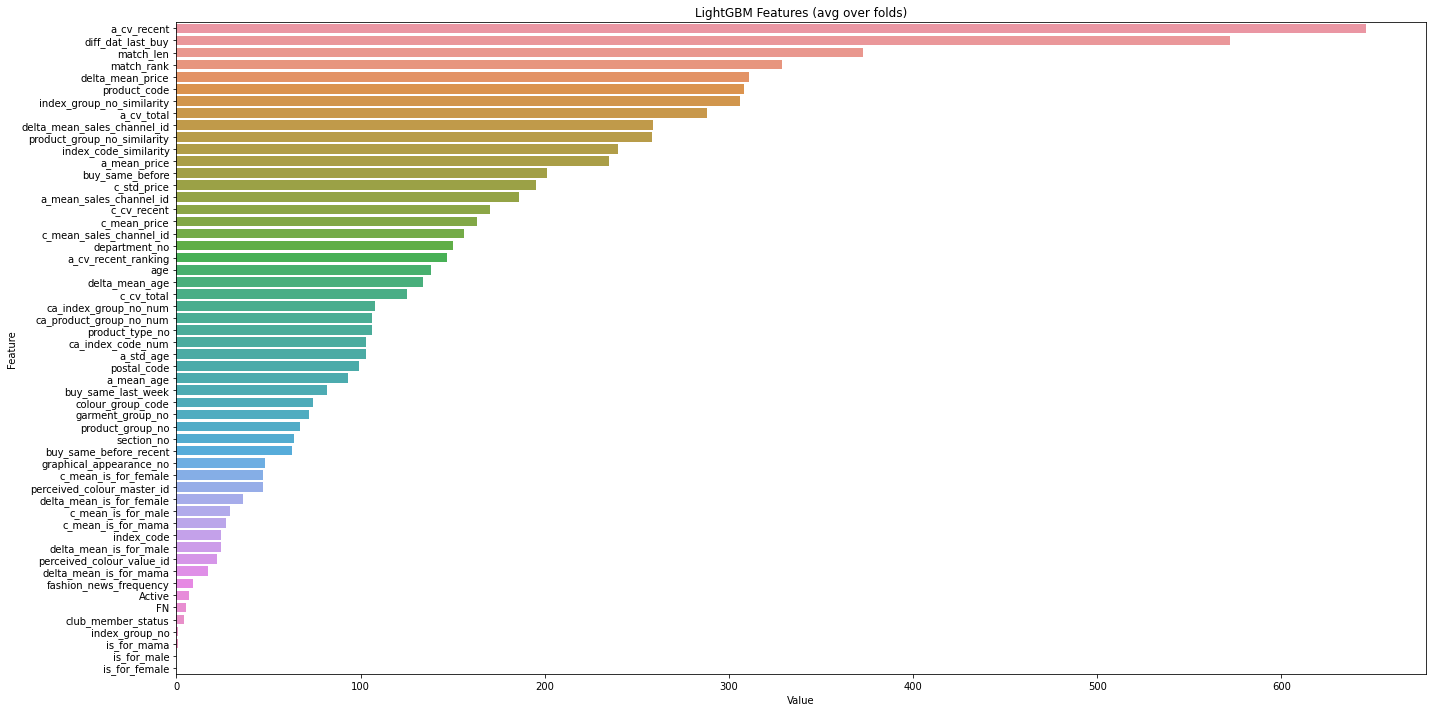

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),model.feature_name())), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

## test

In [24]:
# メモリ節約
del train, train_x, train_y, valid, valid_x, valid_y
gc.collect()

13409

In [25]:
# test data
#Nval = 12
test = dd.read_csv(f'./test.csv', dtype=input_type).compute()
test

,customer_id,match_len,article_id,match_rank,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,...,product_group_no_similarity,buy_same_before,buy_same_before_recent,buy_same_last_week,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama
0,-2324495172285268445,6,736530007,0,True,False,0,4,21,183703,...,0.5,1,0,1,-0.000462,-9,0.287109,0.0,0.0,0.0
1,-2324495172285268445,6,770703004,1,True,False,0,4,21,183703,...,0.5,1,0,1,-0.005836,-12,0.236328,0.0,0.0,0.0
2,-2324495172285268445,6,736531006,2,True,False,0,4,21,183703,...,0.5,0,0,0,0.014046,-10,0.303711,0.0,0.0,0.0
3,-2324495172285268445,6,706016001,3,True,False,0,4,21,183703,...,0.0,0,0,0,-0.008736,-11,0.154297,0.0,0.0,0.0
4,-2324495172285268445,6,611415005,4,True,False,0,4,21,183703,...,0.5,0,0,0,0.007523,-10,0.360352,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125904,-3280349465215843523,6,751471001,25,False,False,0,2,25,61034,...,0.0,0,0,0,0.028671,-12,-0.695312,0.0,0.0,0.0
125905,-3280349465215843523,6,573085028,26,False,False,0,2,25,61034,...,0.0,0,0,0,0.028427,-9,-0.733398,0.0,0.0,0.0
125906,-3280349465215843523,6,850917001,27,False,False,0,2,25,61034,...,1.0,0,0,0,0.036530,-11,-0.780273,0.0,0.0,0.0
125907,-3280349465215843523,6,909059002,28,False,False,0,2,25,61034,...,0.0,0,0,0,0.019379,-4,-1.000000,0.0,0.0,0.0


In [26]:
test.sort_index(inplace=True)

In [27]:
test_id = test[['customer_id', 'article_id']]
test = test.drop(['customer_id', 'article_id'], axis=1)

### prediction

In [28]:
del query_list_train, query_list_valid, lgb_train, lgb_eval, params, feature_imp
gc.collect()

0

In [29]:
test

,match_len,match_rank,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,c_mean_price,c_std_price,...,product_group_no_similarity,buy_same_before,buy_same_before_recent,buy_same_last_week,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama
0,6,0,True,False,0,4,21,183703,0.023712,0.004795,...,0.500000,1,0,1,-0.000462,-9,0.287109,0.000000,0.000000,0.0
0,3,18,False,False,0,2,59,262195,0.033875,0.000000,...,1.000000,0,0,0,-0.016006,16,0.226562,0.000000,0.000000,0.0
0,1,16,False,False,2,2,50,728,0.043671,0.017593,...,0.076923,0,0,0,-0.006207,7,0.226562,0.615234,-0.615234,0.0
0,5,0,True,True,0,4,50,21575,0.021454,0.016129,...,0.133333,1,0,1,0.005260,19,-0.121094,0.000000,0.000000,0.0
0,15,15,False,False,0,2,28,32336,0.021164,0.015396,...,0.230769,0,0,0,-0.020340,-8,0.117188,0.076904,-0.077148,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126134,0,3,True,True,0,4,56,337433,0.000000,0.000000,...,NaN,0,0,0,-0.033478,13,-1.886719,0.000000,-1.000000,0.0
126135,0,4,True,True,0,4,56,337433,0.000000,0.000000,...,NaN,0,0,0,-0.041595,13,-1.678711,0.000000,-1.000000,0.0
126136,0,5,True,True,0,4,56,337433,0.000000,0.000000,...,NaN,0,0,0,-0.032349,19,-1.695312,0.000000,-1.000000,0.0
126137,0,6,True,True,0,4,56,337433,0.000000,0.000000,...,NaN,0,0,0,-0.033142,15,-1.674805,0.000000,-1.000000,0.0


In [30]:
#pred = model.predict(test, num_iteration=200)
pred = model.predict(test, num_iteration=model.best_iteration)
pred.shape, test.shape

((41159400,), (41159400, 54))

In [31]:
del test, model
gc.collect()

4

In [32]:
test_id = test_id.reset_index(drop=True)
pred = pd.Series(pred, name='score')

In [33]:
sub1 = pd.concat([test_id, pred], axis=1)

In [34]:
#sub1 = sub1[['customer_id', 'article_id', 'score']]

In [35]:
sub1

,customer_id,article_id,score
0,-2324495172285268445,736530007,-0.297013
1,5590026213480481190,907188001,0.003067
2,-2295122629271959253,907188001,-0.282278
3,-7538125375680265385,464297007,0.075099
4,-9101269666595702779,924243001,-0.063720
...,...,...,...
41159395,1348895060850955320,928206001,-0.018460
41159396,1348895060850955320,910601003,0.017834
41159397,1348895060850955320,751471001,-0.019365
41159398,1348895060850955320,751471043,-0.016099


In [36]:
sub1 = sub1.sort_values(['customer_id','score'], ascending=False)

In [37]:
sub1 = sub1.groupby('customer_id')['article_id'].apply(list).reset_index(name='prediction')

In [38]:
sub1['prediction'].apply(len)

0          30
1          30
2          30
3          30
4          30
           ..
1371975    30
1371976    30
1371977    30
1371978    30
1371979    30
Name: prediction, Length: 1371980, dtype: int64

In [39]:
sub1['prediction'] = sub1['prediction'].apply(lambda x: x[:12])
sub1['prediction'].apply(len)

0          12
1          12
2          12
3          12
4          12
           ..
1371975    12
1371976    12
1371977    12
1371978    12
1371979    12
Name: prediction, Length: 1371980, dtype: int64

In [40]:
sub1['prediction']

0          [706016001, 673396002, 924243001, 918522001, 7...
1          [910601003, 910601003, 908292002, 903926002, 8...
2          [610776002, 580600006, 915529003, 579541001, 8...
3          [866731001, 562245046, 706016001, 448509014, 9...
4          [910601003, 751471001, 751471043, 924243001, 9...
                                 ...                        
1371975    [706016001, 751471001, 714790020, 448509014, 9...
1371976    [658030020, 685816001, 706016001, 658030011, 7...
1371977    [918292001, 866731001, 915529003, 762846027, 8...
1371978    [565379022, 924243001, 579541001, 673677002, 7...
1371979    [781758003, 781758001, 924243001, 923758001, 9...
Name: prediction, Length: 1371980, dtype: object

In [41]:
# 提出用に元に戻す
sub1['prediction'] = sub1['prediction'].map(lambda x:'0'+' 0'.join(map(str, x)))

In [42]:
sub1

,customer_id,prediction
0,-9223352921020755230,0706016001 0673396002 0924243001 0918522001 07...
1,-9223343869995384291,0910601003 0910601003 0908292002 0903926002 08...
2,-9223321797620987725,0610776002 0580600006 0915529003 0579541001 08...
3,-9223319430705797669,0866731001 0562245046 0706016001 0448509014 09...
4,-9223308614576639426,0910601003 0751471001 0751471043 0924243001 09...
...,...,...
1371975,9223319300843860958,0706016001 0751471001 0714790020 0448509014 09...
1371976,9223333063893176977,0658030020 0685816001 0706016001 0658030011 07...
1371977,9223345314868180224,0918292001 0866731001 0915529003 0762846027 08...
1371978,9223357421094039679,0565379022 0924243001 0579541001 0673677002 07...


## Submit

In [43]:
sub = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv')
del sub['prediction']; gc.collect()
visualize_df(sub)

(1371980, 1)


,customer_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...


In [44]:
sub['customer_id2'] = sub['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')

In [45]:
print(sub.shape, sub1.shape)

(1371980, 2) (1371980, 2)


In [46]:
sub

,customer_id,customer_id2
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,6883939031699146327
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,-7200416642310594310
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,-6846340800584936
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,-94071612138601410
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,-283965518499174310
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,7551062398649767985
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,-9141402131989464905
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,-8286316756823862684
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,2551401172826382186


In [47]:
sub1

,customer_id,prediction
0,-9223352921020755230,0706016001 0673396002 0924243001 0918522001 07...
1,-9223343869995384291,0910601003 0910601003 0908292002 0903926002 08...
2,-9223321797620987725,0610776002 0580600006 0915529003 0579541001 08...
3,-9223319430705797669,0866731001 0562245046 0706016001 0448509014 09...
4,-9223308614576639426,0910601003 0751471001 0751471043 0924243001 09...
...,...,...
1371975,9223319300843860958,0706016001 0751471001 0714790020 0448509014 09...
1371976,9223333063893176977,0658030020 0685816001 0706016001 0658030011 07...
1371977,9223345314868180224,0918292001 0866731001 0915529003 0762846027 08...
1371978,9223357421094039679,0565379022 0924243001 0579541001 0673677002 07...


In [48]:
sub =  pd.merge(sub, sub1, left_on='customer_id2', right_on='customer_id', how='left')
#sub = sub.drop([['customer_id2', 'customer_id_y']], axis=1)

In [49]:
sub = sub[['customer_id_x', 'prediction']].copy()
sub.columns = ['customer_id', 'prediction']
print(sub.shape)

(1371980, 2)


In [50]:
sub

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601006 0568601043 0924243001 0915529003 09...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0924243001 0924243002 0918522001 0915529005 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0805000001 0924243001 0918522001 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0751471001 0720125001 0923758001 0924243002 09...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0730683050 0791587015 0896152002 0791587001 09...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0557599022 0611415001 0924243001 0918522001 07...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0762846008 0762846031 0714790020 0934835001 07...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0762846027 0706016002 0762846027 0762846006 08...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0714790020 0448509014 0935541001 0866731001 09...


In [51]:
#sub = sub[['customer_id', 'valid_pred']].copy()
#sub.columns = ['customer_id', 'prediction']
print(sub.shape)

sub.to_csv('submission.csv', index=False)

(1371980, 2)
